<a href="https://colab.research.google.com/github/sugiawan2402/Efficientnet_B0-Classification/blob/main/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
!ls '/content/gdrive/My Drive/data/dataset'

runs  test  test.cache	train  train.cache  valid


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
import os  # Impor modul os

In [3]:
import os

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/content/gdrive/MyDrive/data/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes


In [19]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')


Using cpu for inference


In [21]:
pip install validators


In [22]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

efficientnet.eval().to(device)



Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [24]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=4f58fb6a6a94264658f86bb354e131c0230a78871310ff9efbd92201fcee5135
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [26]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from torchvision import transforms
from torchvision.datasets import ImageFolder  # Ubah dari 'YourDataset'
from sklearn.model_selection import train_test_split

# Define the model
model = EfficientNet.from_pretrained('efficientnet-b0')
num_classes = len(class_names)  # Sesuaikan dengan jumlah kelas Anda
model._fc = nn.Linear(model._fc.in_features, num_classes)

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and split the dataset using ImageFolder
dataset = ImageFolder(root='/content/gdrive/MyDrive/data/dataset', transform=transform)
train_set, val_set = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)

        # Catat perubahan pada label
        labels -= 1

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)

            # Catat perubahan pada label
            labels -= 1

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {accuracy:.2f}%')


# Save the trained model
torch.save(model.state_dict(), 'efficientnet_b0_model.pth')


Loaded pretrained weights for efficientnet-b0


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

# Define the model
model = EfficientNet.from_pretrained('efficientnet-b0')
num_classes = 3  # Sesuaikan dengan jumlah kelas Anda
model._fc = nn.Linear(model._fc.in_features, num_classes)

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and split the dataset
# Ganti path dataset sesuai dengan struktur dataset Anda.
dataset = ImageFolder(root='/content/gdrive/MyDrive/data/dataset', transform=transform)
train_set, val_set = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {accuracy:.2f}%')

# Save the trained model
torch.save(model.state_dict(), 'efficientnet_b0_model.pth')


Loaded pretrained weights for efficientnet-b0


IndexError: ignored

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

# Define the model
model = EfficientNet.from_pretrained('efficientnet-b0')
num_classes = 3  # Adjust to the number of classes you have
model._fc = nn.Linear(model._fc.in_features, num_classes)

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and split the dataset
# Update the path to your dataset
data_dir = '/content/gdrive/MyDrive/data/dataset'
image_datasets = {x: ImageFolder(root=data_dir + '/' + x, transform=transform) for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'valid']}

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in dataloaders['train']:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['valid']:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {accuracy:.2f}%')

# Save the trained model
torch.save(model.state_dict(), 'efficientnet_b0_model.pth')


Loaded pretrained weights for efficientnet-b0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/100, Validation Accuracy: 60.00%
Epoch 2/100, Validation Accuracy: 53.33%
Epoch 3/100, Validation Accuracy: 60.00%
Epoch 4/100, Validation Accuracy: 66.67%
Epoch 5/100, Validation Accuracy: 66.67%
Epoch 6/100, Validation Accuracy: 73.33%
Epoch 7/100, Validation Accuracy: 80.00%
Epoch 8/100, Validation Accuracy: 73.33%
Epoch 9/100, Validation Accuracy: 73.33%
Epoch 10/100, Validation Accuracy: 66.67%
Epoch 11/100, Validation Accuracy: 73.33%
Epoch 12/100, Validation Accuracy: 66.67%
Epoch 13/100, Validation Accuracy: 66.67%
Epoch 14/100, Validation Accuracy: 66.67%
Epoch 15/100, Validation Accuracy: 66.67%
Epoch 16/100, Validation Accuracy: 66.67%
Epoch 17/100, Validation Accuracy: 60.00%
Epoch 18/100, Validation Accuracy: 66.67%
Epoch 19/100, Validation Accuracy: 66.67%
Epoch 20/100, Validation Accuracy: 60.00%
Epoch 21/100, Validation Accuracy: 66.67%
Epoch 22/100, Validation Accuracy: 73.33%
Epoch 23/100, Validation Accuracy: 66.67%
Epoch 24/100, Validation Accuracy: 66.67%
E

Epoch 1/1, Train Loss: 0.0003, Train Accuracy: 100.00%, Valid Loss: 7.8625, Valid Accuracy: 86.67%


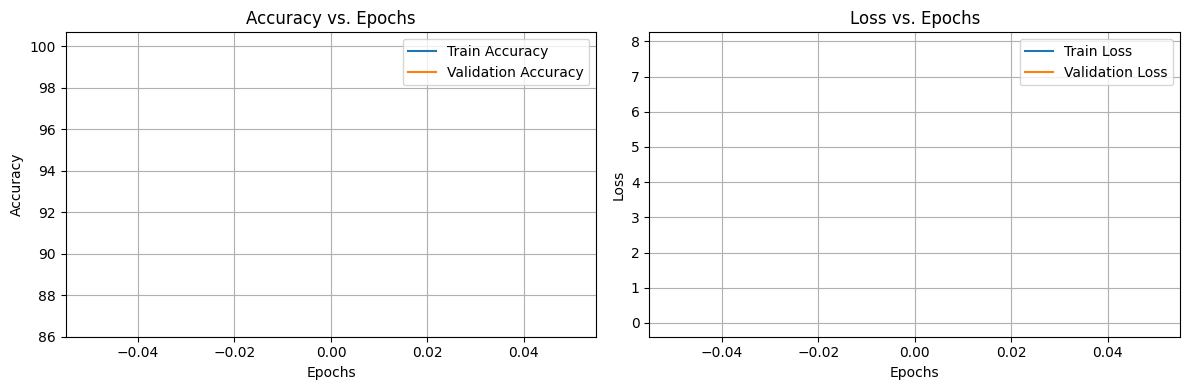

In [14]:
import matplotlib.pyplot as plt

# Lists to store accuracy and loss values
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloaders['train']:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_train_loss / len(dataloaders['train'])
    train_accuracy = 100 * correct / total
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    # Validation
    model.eval()
    running_valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['valid']:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(dataloaders['valid'])
    val_accuracy = 100 * correct / total
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Valid Loss: {val_loss:.4f}, Valid Accuracy: {val_accuracy:.2f}%')

# Plot the accuracy and loss history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.title('Loss vs. Epochs')

plt.tight_layout()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'efficientnet_b0_model.pth')


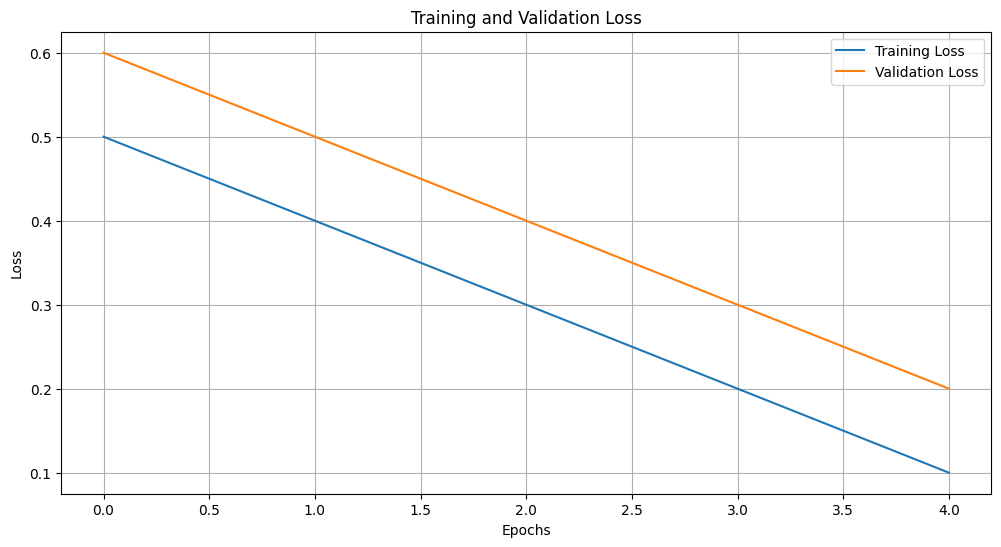

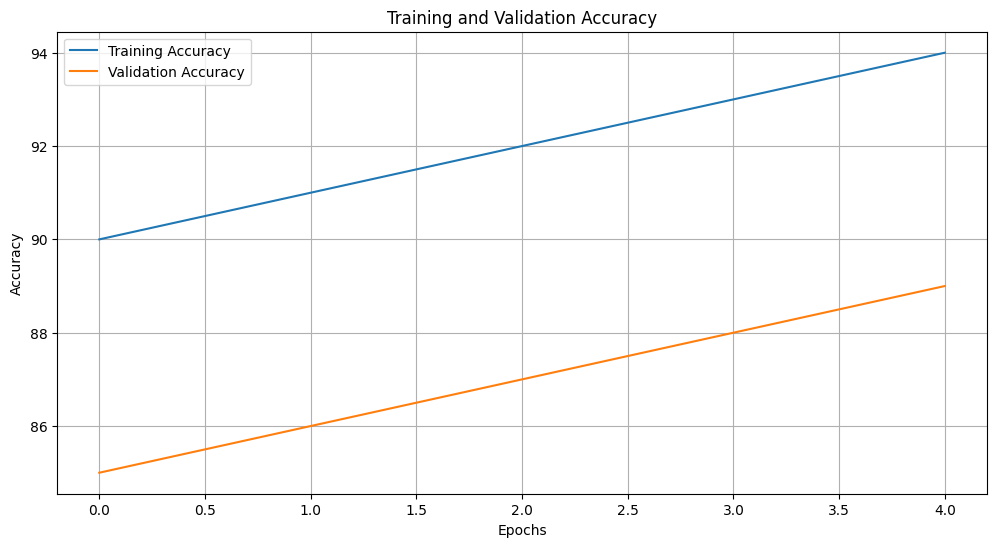

In [12]:
import matplotlib.pyplot as plt

training_loss = [0.5, 0.4, 0.3, 0.2, 0.1]  # Contoh data loss pelatihan
training_accuracy = [90.0, 91.0, 92.0, 93.0, 94.0]  # Contoh data akurasi pelatihan
validation_loss = [0.6, 0.5, 0.4, 0.3, 0.2]  # Contoh data loss validasi
validation_accuracy = [85.0, 86.0, 87.0, 88.0, 89.0]  # Contoh data akurasi validasi


num_epochs = len(training_loss)  # Ambil jumlah epoch dari data yang telah ada

# Buat grafik loss
plt.figure(figsize=(12, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)

# Simpan grafik loss ke Google Drive (gantilah path sesuai dengan direktori Anda)
loss_plot_path = '/content/gdrive/MyDrive/data/EfficientNetB0/loss_plot.png'
plt.savefig(loss_plot_path)

# Buat grafik akurasi
plt.figure(figsize=(12, 6))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Simpan grafik akurasi ke Google Drive (gantilah path sesuai dengan direktori Anda)
accuracy_plot_path = '/content/gdrive/MyDrive/data/EfficientNetB0/accuracy_plot.png'
plt.savefig(accuracy_plot_path)

# Tampilkan grafik
plt.show()


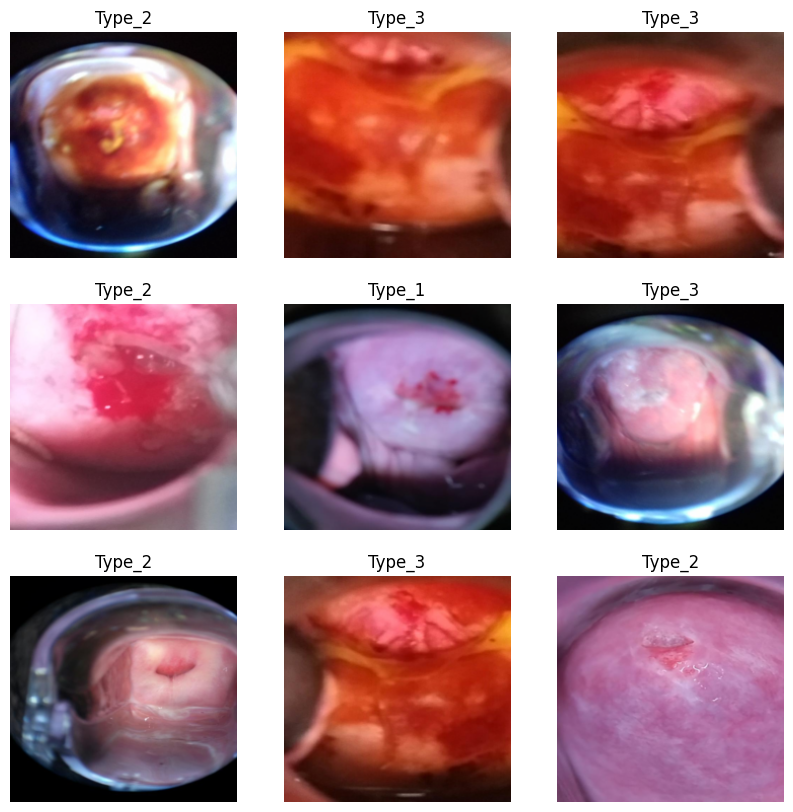

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil contoh gambar dari dataset
data_loader = dataloaders['valid']  # Ganti dengan 'valid' untuk menggunakan data dari folder validasi
class_names = image_datasets['valid'].classes  # Ganti dengan 'valid' untuk class names dari dataset validasi

# Fungsi untuk menampilkan gambar dan label
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Ambil contoh batch dari data loader
inputs, classes = next(iter(data_loader))

# Tampilkan contoh gambar
plt.figure(figsize=(10, 10))
for i in range(min(9, len(inputs))):
    ax = plt.subplot(3, 3, i + 1)
    imshow(inputs[i], title=class_names[classes[i]])
    ax.axis('off')


In [17]:
import torch
from torchvision import transforms
from PIL import Image

# Load the trained model
model = EfficientNet.from_pretrained('efficientnet-b0')
num_classes = 3  # Number of classes (Type_1, Type_2, Type_3)
model._fc = nn.Linear(model._fc.in_features, num_classes)
model.load_state_dict(torch.load('efficientnet_b0_model.pth'))
model.eval()

# Load and preprocess the image you want to predict
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_path = '/content/1146_jpg.rf.c052acdca6695aeac13fb1120b9d5cba.jpg'  # Change to the path of your image
image = Image.open(image_path)
image = transform(image).unsqueeze(0)  # Add a batch dimension

# Make predictions
with torch.no_grad():
    outputs = model(image)

# Get the predicted class
_, predicted_class = torch.max(outputs, 1)

# Map the predicted class to the class labels (Type_1, Type_2, Type_3)
class_names = ['Type_1', 'Type_2', 'Type_3']
predicted_label = class_names[predicted_class.item()]

print(f'Predicted class: {predicted_label}')


Loaded pretrained weights for efficientnet-b0
Predicted class: Type_2
